In [ ]:
#RQ2 - events and their impact on traffic.
#find topics in the event-related tweets

In [1]:
import numpy as np
import lda
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings("ignore")

In [ ]:
cd "your directory"

In [14]:
tweets= pd.read_csv('event_tweets.csv')

In [15]:
tweets

,text,ID
0,#RedEye starts now,0
1,Now they are going to tell me that I can't wat...,0
2,The poor husband #RedEye,0
3,â@LeoOfMars: Let's get the #RedEye live twee...,0
4,@rachelveronica damn autocorrect,0
...,...,...
15059,#RedFlags when he feels that Twitter hashtags ...,837
15060,"#RedFlags when he thinks the word ""impotent"" r...",837
15061,#RedFlags when he talks of finding a home insi...,837
15062,#RedFlags when there is a rainstorm and he sta...,837


In [16]:
#remove emojis
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [19]:
#preprocess the tweets to remove emojis, https, @users, punctuation signs, stop words
#keep only English letters
tweets['text_processed']=tweets['text'].apply(lambda x: ' '.join([item.encode('latin-1', 'ignore').decode( 'utf-8') for item in x.split(' ') if ('http' not in item) and ('@' not in item)]))
tweets['text_processed']=tweets['text_processed'].str.lower()
tweets['text_processed']=tweets['text_processed'].apply(remove_emojis)

punctuation_signs = list("?:!.,;")
for punct_sign in punctuation_signs:
    tweets['text_processed'] =tweets['text_processed'].str.replace(punct_sign, '')
    
tweets['text_processed'] = tweets['text_processed'].str.replace("[^a-zA-Z#]", " ")
tweets['text_processed']=tweets['text_processed'].str.replace("'s", "")

stop_words = list(stopwords.words('english'))

for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    tweets['text_processed']=tweets['text_processed'].str.replace(regex_stopword, '')
    

In [20]:
#lemmatize the words
wordnet_lemmatizer = WordNetLemmatizer()

nrows = len(tweets)
lemmatized_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = tweets.loc[row]['text_processed']
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

tweets['text_processed'] = lemmatized_text_list

In [21]:
tweets.head(10)

,text,ID,text_processed
0,#RedEye starts now,0,#redeye start
1,Now they are going to tell me that I can't wat...,0,going tell watch duke hazard anymore...
2,The poor husband #RedEye,0,poor husband #redeye
3,â@LeoOfMars: Let's get the #RedEye live twee...,0,let get #redeye live tweet back normal hey ...
4,@rachelveronica damn autocorrect,0,damn autocorrect
5,"@GweninAlaska damn autocorrect , I'm too lazy ...",0,damn autocorrect lazy fix
6,These No No commercials #redeye,0,commercial #redeye
7,@rachelveronica one day!!,0,one day
8,@GweninAlaska I have to pay more attention aft...,0,pay attention ha
9,@rachelveronica why??,0,


In [22]:
tweets.shape

(15064, 3)

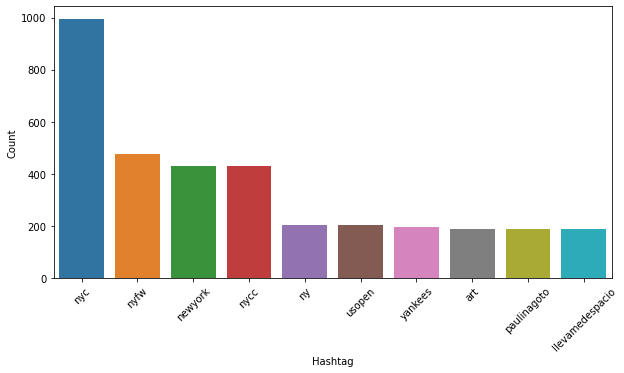

In [12]:
#let's see what are the most frequent words in the tweets
def hashtag_extract(x):
    hashtags = []    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

HT_ = hashtag_extract(tweets['text_processed']) 

HT_regular = []
for x in HT_:
    HT_regular += x
    

a = nltk.FreqDist(HT_regular)
d = pd.DataFrame(
    {
    'Hashtag': list(a.keys()),
    'Count': list(a.values())
    }
) 

d = d.nlargest(columns="Count", n = 10)
plt.figure(figsize=(10,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
#build topic model using LDA
#I chose to have 5 topics after running the model with different n_topics from 2 to 10
#and decided when n_topic = 5 it generates most meaningful results

In [13]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print("; ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [18]:
#concert the tweets into a matrix using count vectorizer
#columns = words
#rows = each tweet
count_vectorizer = CountVectorizer(min_df = 10 )
count = count_vectorizer.fit_transform(tweets['text_processed'])

In [19]:
#LDA model
model = lda.LDA(n_topics=5, n_iter=1500, random_state=100)

In [22]:
#fit model to our dataset
#note: some of them have 0s because the row is blank after cleaning, meaning the rows were all emojis or https, etc
#I ignored those cases since they are rare
model.fit(count)

INFO:lda:n_documents: 15064
INFO:lda:vocab_size: 1519
INFO:lda:n_words: 80928
INFO:lda:n_topics: 5
INFO:lda:n_iter: 1500
INFO:lda:<0> log likelihood: -756488
INFO:lda:<10> log likelihood: -542288
INFO:lda:<20> log likelihood: -518682
INFO:lda:<30> log likelihood: -510134
INFO:lda:<40> log likelihood: -505930
INFO:lda:<50> log likelihood: -503981
INFO:lda:<60> log likelihood: -502519
INFO:lda:<70> log likelihood: -501438
INFO:lda:<80> log likelihood: -500933
INFO:lda:<90> log likelihood: -500365
INFO:lda:<100> log likelihood: -500285
INFO:lda:<110> log likelihood: -499987
INFO:lda:<120> log likelihood: -500002
INFO:lda:<130> log likelihood: -499737
INFO:lda:<140> log likelihood: -499690
INFO:lda:<150> log likelihood: -499964
INFO:lda:<160> log likelihood: -499399
INFO:lda:<170> log likelihood: -498838
INFO:lda:<180> log likelihood: -498770
INFO:lda:<190> log likelihood: -498419
INFO:lda:<200> log likelihood: -498399
INFO:lda:<210> log likelihood: -498660
INFO:lda:<220> log likelihood: -

In [24]:
# Print the topics found by the LDA model
#I read them to decide their meaning manually
print("Topics found via LDA:")
print_topics(model, count_vectorizer, 15)

Topics found via LDA:

Topic #0:
new; york; time; square; city; nyc; ny; de; con; comic; happy; en; newyork; year; la

Topic #1:
stadium; yankee; field; citi; metlife; mets; game; go; ny; ball; festival; let; island; day; bronx

Topic #2:
nyfw; see; nyc; skylight; tennis; one; show; open; love; full; amp; usopen; fashion; time; selfie

Topic #3:
center; nyc; nycc; park; barclays; art; museum; brooklyn; central; memorial; javits; newyork; love; ny; moma

Topic #4:
square; madison; garden; happy; make; design; game; art; arianators; fanarmyfaceoff; special; birthday; madonna; th; smile


In [26]:
#I manually summarize the meanings of each topic
category_codes = {
0:'genral nyc',
1:'sports',
2:'fashin',
3:'art and museum',
4:'concerts'
}

In [25]:
model.components_

array([[6.10754532e-07, 1.22211982e-03, 6.10754532e-07, ...,
        6.10754532e-07, 6.10754532e-07, 6.10754532e-07],
       [5.66951598e-07, 5.66951598e-07, 5.66951598e-07, ...,
        3.68575234e-03, 5.66951598e-07, 5.66951598e-07],
       [4.42376286e-07, 4.42376286e-07, 5.31293920e-04, ...,
        4.42376286e-07, 4.42376286e-07, 4.42376286e-07],
       [1.62525653e-03, 7.73563319e-07, 7.73563319e-07, ...,
        7.73563319e-07, 1.00640588e-03, 7.73563319e-07],
       [6.11682703e-04, 8.72585882e-07, 8.72585882e-07, ...,
        8.72585882e-07, 8.72585882e-07, 1.22249282e-03]])

In [27]:
#get most likely tpoic for each tweet 
res=model.transform(count)

In [28]:
#get category labels for the tweets
labels = []
for line in res:
    i=np.where(line == np.amax(line))[0][0]
    labels.append(i)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [29]:
tweets['label']=labels

In [30]:
#results
tweets

,text,ID,text_processed,label
0,#RedEye starts now,0,#redeye start,2
1,Now they are going to tell me that I can't wat...,0,going tell watch duke hazard anymore...,2
2,The poor husband #RedEye,0,poor husband #redeye,4
3,â@LeoOfMars: Let's get the #RedEye live twee...,0,let get #redeye live tweet back normal hey ...,2
4,@rachelveronica damn autocorrect,0,damn autocorrect,1
...,...,...,...,...
15059,#RedFlags when he feels that Twitter hashtags ...,837,#redflags feel twitter hashtags really top...,2
15060,"#RedFlags when he thinks the word ""impotent"" r...",837,#redflags think word impotent refers r...,2
15061,#RedFlags when he talks of finding a home insi...,837,#redflags talk finding home inside monastery,2
15062,#RedFlags when there is a rainstorm and he sta...,837,#redflags rainstorm start building ark ...,2
